In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Requirements

- DIY classification algorithm (i.e. perceptron)
- Compare results with scikit-learn implementation
- Train and test with different dataset partitions, compare metrics
- Validate and compare different models and/or parameter sets
- Feature engineering (various feature combinations, polynomial features, etc)
- Interpret results

# Preparation

Data source: https://www.kaggle.com/ueslei/ucs-satellite-database

In [2]:
df = pd.read_csv('UCS_Satellite_Database_12-1-2018-1.csv',
    engine='python', decimal=',', thousands='.', parse_dates=['Date of Launch'], dayfirst=True)

# Remove some columns
df.drop(df.columns[df.columns.tolist().index('Comments')+1:], axis=1, inplace=True)

# Type conversions
df['Eccentricity'] = df['Eccentricity'].replace(',', '.', regex=True).astype(float)
df['Inclination (degrees)'] = df['Inclination (degrees)'].replace(',', '.', regex=True).astype(float)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Name of Satellite, Alternate Names  1957 non-null   object        
 1   Country/Org of UN Registry          1957 non-null   object        
 2   Country of Operator/Owner           1957 non-null   object        
 3   Operator/Owner                      1957 non-null   object        
 4   Users                               1957 non-null   object        
 5   Purpose                             1957 non-null   object        
 6   Detailed Purpose                    720 non-null    object        
 7   Class of Orbit                      1955 non-null   object        
 8   Type of Orbit                       1348 non-null   object        
 9   Longitude of GEO (degrees)          1956 non-null   object        
 10  Perigee (km)            

In [4]:
# Basic metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred):
    print(f'Accuracy : {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred):.2f}')
    print(f'Recall   : {recall_score(y_true, y_pred):.2f}')
    print(f'F1-score : {f1_score(y_true, y_pred):.2f}')

In [5]:
# Decision boundary plot


# Adapted from:
# https://gist.github.com/anandology/772d44d291a9daa198d4

def plot_decision_boundaries(X, y, feature_labels, class_labels, model=None):
    """Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    
    One possible improvement could be to use all columns fot fitting
    and using the first 2 columns and median of all other columns
    for predicting.
    
    Adopted from:
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """
    reduced_data = X[:, :2]

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, m_max]x[y_min, y_max].    
    margin = 0.5

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - margin, reduced_data[:, 0].max() + margin
    y_min, y_max = reduced_data[:, 1].min() - margin, reduced_data[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    if model:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if model:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolors='black')
    plt.xlabel(feature_labels[0])
    plt.ylabel(feature_labels[1])
#     plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)
#     plt.legend()
    return plt

Text(0.5, 1.0, 'Users')

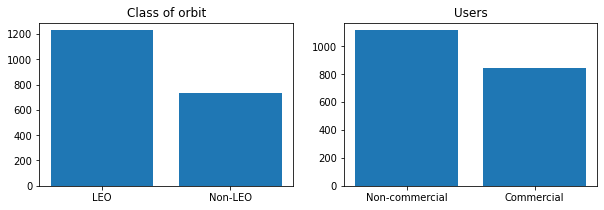

In [6]:
# Merging some smaller classes into one
df['COO'] = df['Class of Orbit'].apply(lambda x: x if x == 'LEO' else 'Non-LEO')
df['U'] = df['Users'].apply(lambda x: x if x == 'Commercial' else 'Non-commercial')


# Visualize them
def plot_counts(df, col):
    users_count2 = df.groupby(col)[col].agg(['count']).reset_index()
    users_count2.sort_values('count', ascending=False, inplace=True)
    plt.bar(users_count2[col], users_count2['count'])
    
fig = plt.figure(figsize=(10, 3))

fig.add_subplot(121)
plot_counts(df, 'COO')
plt.title('Class of orbit')

fig.add_subplot(122)
plot_counts(df, 'U')
plt.title('Users')

# Experiments

## Train/test split

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# NOTE: requires scikit-learn version 0.22.2
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

# Rejecting some rows with null values
filter1 = (df['Launch Mass (kg.)'].notnull())
df_filtered = df[filter1].reset_index()

# Train/test row indexes
train_indexes, test_indexes = train_test_split(df_filtered.index, random_state=100)

# Using two input features
X = df_filtered[['Inclination (degrees)', 'Launch Mass (kg.)']].values
feature_names = ['Inclination', 'Launch mass']

# Normalize the inputs
X = StandardScaler().fit_transform(X)

# Prepare inputs
X_train, X_test = X[train_indexes], X[test_indexes]

# Prepare outputs
le_orbit, le_users = LabelEncoder(), LabelEncoder()
y_orbit = le_orbit.fit_transform(df_filtered['COO'])
y_users = le_users.fit_transform(df_filtered['U'])
y_orbit_train, y_orbit_test = y_orbit[train_indexes], y_orbit[test_indexes]
y_users_train, y_users_test = y_users[train_indexes], y_users[test_indexes]

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Orbit class prediction

In [9]:
lr_orbit1 = LogisticRegression()
dt_orbit1 = DecisionTreeClassifier()

lr_orbit1.fit(X_train, y_orbit_train)
dt_orbit1.fit(X_train, y_orbit_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Text(0.5, 1.0, 'Decision tree')

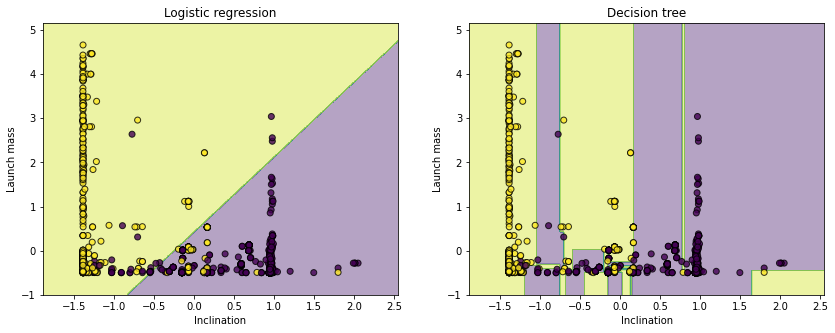

In [10]:
fig = plt.figure(figsize=(14, 5))

fig.add_subplot(121)
plot_decision_boundaries(X_train, y_orbit_train, 
                         feature_names, le_orbit.classes_, lr_orbit1)
plt.title('Logistic regression')

fig.add_subplot(122)
plot_decision_boundaries(X_train, y_orbit_train, 
                         feature_names, le_orbit.classes_, dt_orbit1)
plt.title('Decision tree')

In [11]:
print('Logistic regression')
print('-------------------')
print('Training set:')
print_metrics(y_orbit_train, lr_orbit1.predict(X_train))

print()
print('Test set:')
print_metrics(y_orbit_test, lr_orbit1.predict(X_test))

Logistic regression
-------------------
Training set:
Accuracy : 0.91
Precision: 0.92
Recall   : 0.83
F1-score : 0.87

Test set:
Accuracy : 0.90
Precision: 0.93
Recall   : 0.80
F1-score : 0.86


In [12]:
print('Decision tree')
print('-------------------')
print('Training set:')
print_metrics(y_orbit_train, dt_orbit1.predict(X_train))

print()
print('Test set:')
print_metrics(y_orbit_test, dt_orbit1.predict(X_test))

Decision tree
-------------------
Training set:
Accuracy : 1.00
Precision: 1.00
Recall   : 1.00
F1-score : 1.00

Test set:
Accuracy : 0.98
Precision: 0.99
Recall   : 0.96
F1-score : 0.98


Text(0.5, 1.0, 'Decision tree')

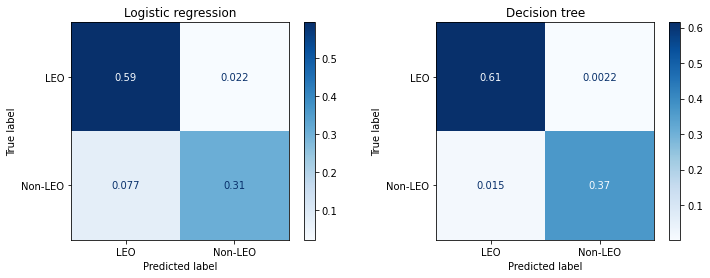

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_confusion_matrix(lr_orbit1, X_test, y_orbit_test,
                      cmap=plt.cm.Blues, normalize='all', 
                      display_labels=le_orbit.classes_, ax=ax1)
ax1.set_title('Logistic regression')

plot_confusion_matrix(dt_orbit1, X_test, y_orbit_test,
                      cmap=plt.cm.Blues, normalize='all', 
                      display_labels=le_orbit.classes_, ax=ax2)
ax2.set_title('Decision tree')

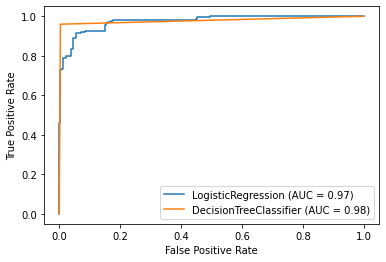

In [14]:
roc = plot_roc_curve(lr_orbit1, X_test, y_orbit_test)
plot_roc_curve(dt_orbit1, X_test, y_orbit_test, ax=roc.ax_)

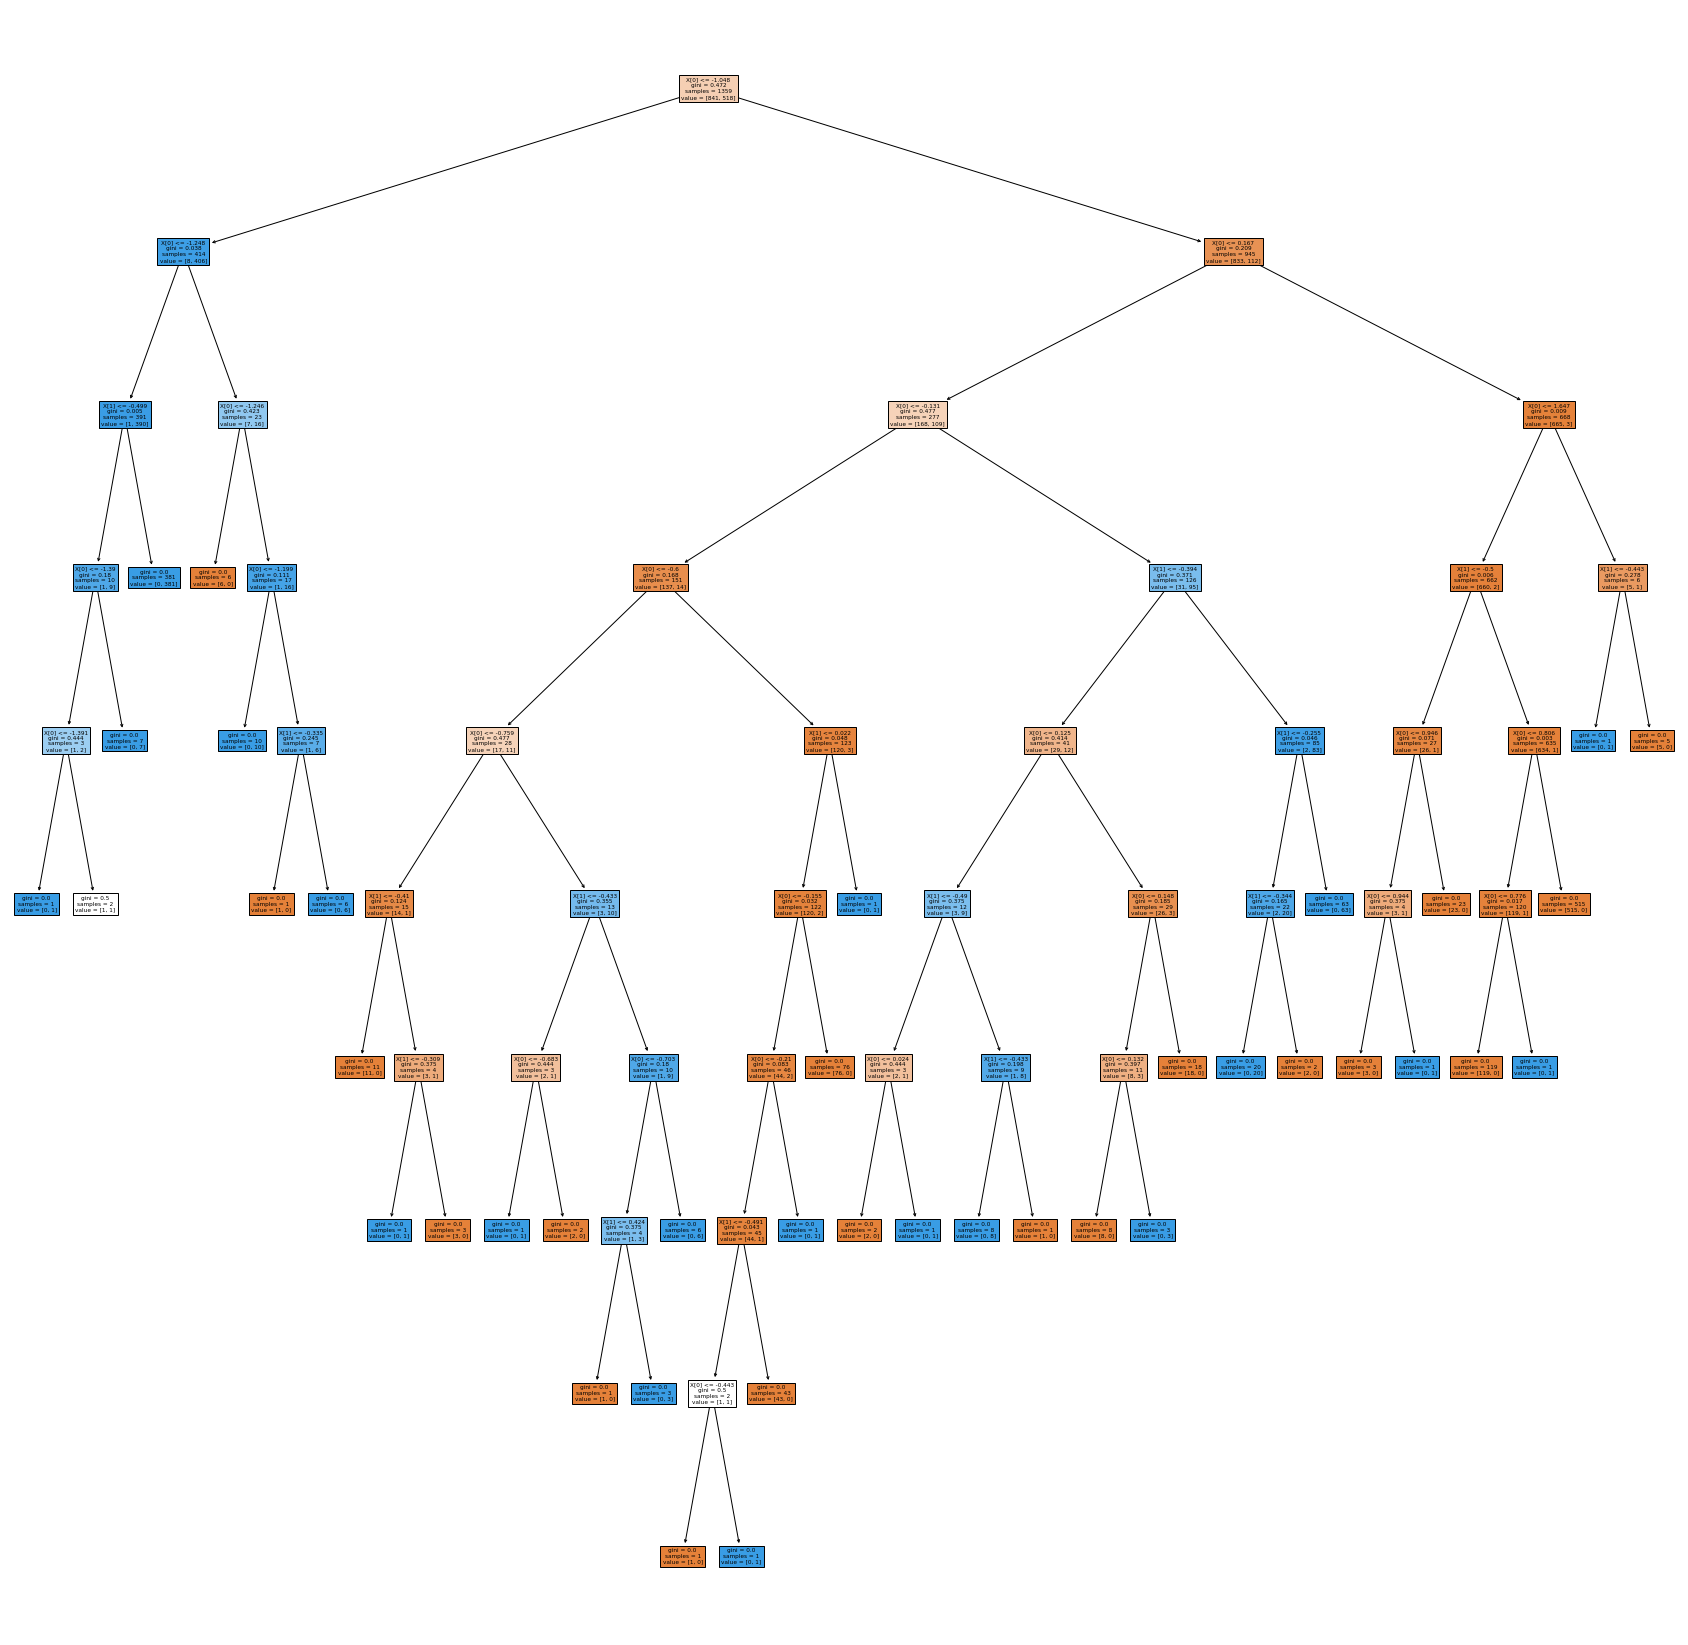

In [15]:
# Decision tree visualization
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 30))
plot_tree(dt_orbit1, filled=True)
plt.show()

## User type prediction

In [16]:
lr_users1 = LogisticRegression()
dt_users1 = DecisionTreeClassifier()

lr_users1.fit(X_train, y_users_train)
dt_users1.fit(X_train, y_users_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Text(0.5, 1.0, 'Decision tree')

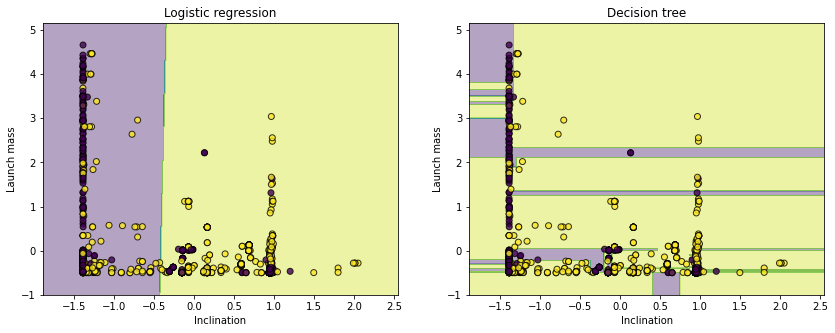

In [17]:
fig = plt.figure(figsize=(14, 5))

fig.add_subplot(121)
plot_decision_boundaries(X_train, y_users_train, 
                         feature_names, le_users.classes_, lr_users1)
plt.title('Logistic regression')

fig.add_subplot(122)
plot_decision_boundaries(X_train, y_users_train, 
                         feature_names, le_users.classes_, dt_users1)
plt.title('Decision tree')

In [18]:
print('Logistic regression')
print('-------------------')
print('Training set:')
print_metrics(y_users_train, lr_users1.predict(X_train))

print()
print('Test set:')
print_metrics(y_users_test, lr_users1.predict(X_test))

Logistic regression
-------------------
Training set:
Accuracy : 0.58
Precision: 0.59
Recall   : 0.73
F1-score : 0.65

Test set:
Accuracy : 0.60
Precision: 0.62
Recall   : 0.75
F1-score : 0.68


In [19]:
print('Decision tree')
print('-------------------')
print('Training set:')
print_metrics(y_users_train, dt_users1.predict(X_train))

print()
print('Test set:')
print_metrics(y_users_test, dt_users1.predict(X_test))

Decision tree
-------------------
Training set:
Accuracy : 0.99
Precision: 1.00
Recall   : 0.98
F1-score : 0.99

Test set:
Accuracy : 0.86
Precision: 0.88
Recall   : 0.86
F1-score : 0.87


Text(0.5, 1.0, 'Decision tree')

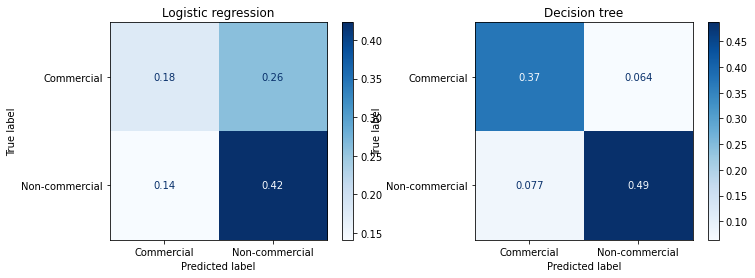

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_confusion_matrix(lr_users1, X_test, y_users_test,
                      cmap=plt.cm.Blues, normalize='all', 
                      display_labels=le_users.classes_, ax=ax1)
ax1.set_title('Logistic regression')

plot_confusion_matrix(dt_users1, X_test, y_users_test,
                      cmap=plt.cm.Blues, normalize='all', 
                      display_labels=le_users.classes_, ax=ax2)
ax2.set_title('Decision tree')

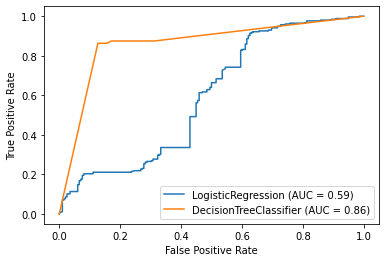

In [21]:
roc = plot_roc_curve(lr_users1, X_test, y_users_test)
plot_roc_curve(dt_users1, X_test, y_users_test, ax=roc.ax_)

## Feature engineering

In [22]:
# Using additional features

X2 = df_filtered[[
    'Inclination (degrees)', 'Launch Mass (kg.)',
    'Perigee (km)', 'Apogee (km)']].values
X2 = StandardScaler().fit_transform(X2)
X2_train, X2_test = X2[train_indexes], X2[test_indexes]

X3 = df_filtered[[
    'Inclination (degrees)', 'Launch Mass (kg.)',
    'Perigee (km)', 'Apogee (km)',
    'Eccentricity', 'Period (minutes)',]].values
X3 = StandardScaler().fit_transform(X3)
X3_train, X3_test = X3[train_indexes], X3[test_indexes]

In [23]:
lr_users2 = LogisticRegression()
lr_users3 = LogisticRegression()

lr_users2.fit(X2_train, y_users_train)
lr_users3.fit(X3_train, y_users_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
print('Logistic regression (4 features)')
print('-------------------')
print('Training set:')
print_metrics(y_users_train, lr_users2.predict(X2_train))

print()
print('Test set:')
print_metrics(y_users_test, lr_users2.predict(X2_test))

Logistic regression (4 features)
-------------------
Training set:
Accuracy : 0.60
Precision: 0.60
Recall   : 0.73
F1-score : 0.66

Test set:
Accuracy : 0.63
Precision: 0.64
Recall   : 0.77
F1-score : 0.70


In [25]:
print('Logistic regression (6 features)')
print('-------------------')
print('Training set:')
print_metrics(y_users_train, lr_users3.predict(X3_train))

print()
print('Test set:')
print_metrics(y_users_test, lr_users3.predict(X3_test))

Logistic regression (6 features)
-------------------
Training set:
Accuracy : 0.62
Precision: 0.63
Recall   : 0.70
F1-score : 0.66

Test set:
Accuracy : 0.61
Precision: 0.64
Recall   : 0.72
F1-score : 0.68


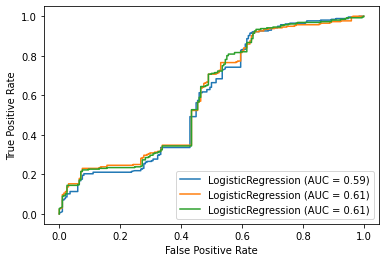

In [26]:
roc = plot_roc_curve(lr_users1, X_test, y_users_test)
plot_roc_curve(lr_users2, X2_test, y_users_test, ax=roc.ax_)
plot_roc_curve(lr_users3, X3_test, y_users_test, ax=roc.ax_)

# More ideas
- Different models (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Model parameter tuning
- Binary vs multiclass classification
- Feature engineering (polynomial features, etc)